In [24]:
!pip install torch torchvision numpy pandas scikit-learn matplotlib opencv-python onnx onnxruntime termcolor


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [25]:
import torch
import torch.onnx
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import cv2
from shutil import copy2
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import pandas as pd
from termcolor import colored 


In [3]:
print(torch.__version__)

2.4.0+cu121


In [4]:
# Define path and load data
image_dir = 'cut/images'
label_dir = 'cut/labels'
output_dirs = {
    'train': 'cut/split/train',
    'val': 'cut/split/val',
    'test': 'cut/split/test'
}

# Ensure output directories exist
for path in output_dirs.values():
    os.makedirs(path, exist_ok=True)

# List all images and corresponding label files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]

# Sort to make sure images and labels are matched
image_files.sort()
label_files.sort()

# Check if we have a matching number of image and label files
assert len(image_files) == len(label_files), "Mismatch between number of images and labels"

In [5]:
# Load Label and create DataFrame
def read_label(label_file):
    with open(os.path.join(label_dir, label_file), 'r') as f:
        label = int(f.read().strip())
    return label

data = []
for img_file, lbl_file in zip(image_files, label_files):
    label = read_label(lbl_file)
    data.append({'image': img_file, 'labels': label})

df = pd.DataFrame(data)

In [6]:
# Print sample of data frame 
print(df.head(4))

                             image  labels
0   gt_2024-09-04_14-26-59_1_1.png       0
1  gt_2024-09-04_14-26-59_1_10.png       1
2  gt_2024-09-04_14-26-59_1_11.png       0
3  gt_2024-09-04_14-26-59_1_12.png       1


In [7]:
# Split data
train_df, test_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Check the number of samples in each split
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 297
Validation samples: 99
Test samples: 99


In [8]:
# Copy files to corresponding directories
def copy_files(df, split):
    for _, row in df.iterrows():
        img_path = os.path.join(image_dir, row['image'])
        dest_path = os.path.join(output_dirs[split], row['image'])
        copy2(img_path, dest_path)

# Copy files for each split
copy_files(train_df, 'train')
copy_files(val_df, 'val')
copy_files(test_df, 'test')

In [9]:
# Verify data preparation
def count_files(dir_path):
    return len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])

print(f"Training images: {count_files(output_dirs['train'])}")
print(f"Validation images: {count_files(output_dirs['val'])}")
print(f"Test images: {count_files(output_dirs['test'])}")

Training images: 297
Validation images: 99
Test images: 99


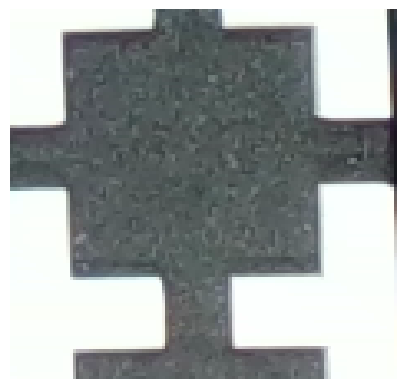

In [10]:
# Show image
random_file = random.choice(os.listdir(output_dirs['train']))
image = cv2.imread(os.path.join("cut", "split", "train", random_file))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [15]:

class CustomDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(image_name).convert('RGB')
        label = int(self.dataframe.iloc[idx, 1:])
        label = torch.tensor(label, dtype=torch.int8)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [16]:

# Define transformations for the training and validation data
transform = transforms.Compose([
    # transforms.Resize((117, 112)),  # Resize to match the image resolution
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Create datasets
train_dataset = CustomDataset(dataframe=train_df, image_dir=output_dirs['train'], transform=transform)
val_dataset = CustomDataset(dataframe=val_df, image_dir=output_dirs['val'], transform=transform)
test_dataset = CustomDataset(dataframe=test_df, image_dir=output_dirs['test'], transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
model = models.efficientnet_b0(pretrained=True)

model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 1),
    nn.Sigmoid()
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/home/aleks/master-lab/cobot_model/.venv/lib64/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aleks/master-lab/cobot_model/.venv/lib64/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# Train Model with Early Stopping for Binary Classification (1 output neuron with Sigmoid)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure labels are on the correct device

            optimizer.zero_grad()
            outputs = model(inputs).squeeze()  # Forward pass and remove extra dimensions
            
            # Compute loss (labels should be scalar tensors and outputs should not be passed through sigmoid)
            loss = criterion(outputs, labels.float())  # Ensure labels are float for BCEWithLogitsLoss
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()  # Forward pass
                
                loss = criterion(outputs, labels.float())  # Compute loss for validation
                val_loss += loss.item() * inputs.size(0)
                
                # Apply sigmoid to outputs and convert to binary predictions
                preds = torch.sigmoid(outputs).cpu().numpy()
                val_preds.extend((preds > 0.5).astype(int))  # Convert probabilities to binary predictions
                val_labels.extend(labels.cpu().numpy())
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = np.mean(np.equal(np.array(val_preds), np.array(val_labels)))
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)
                
        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_without_improvement = 0
            
            # Save the best model as .pth
            torch.save(model.state_dict(), 'model/best_model_new.pth')
            
            # Save the best model as ONNX
            example_input = torch.randn(1, 3, 117, 112).to(device)  # Example input for ONNX export
            torch.onnx.export(model,
                              example_input,                         # Model input
                              'model/best_model_new.onnx',           # File to save the ONNX model
                              export_params=True,                    # Store the trained weights
                              opset_version=11,                      # ONNX version
                              input_names=['input'],                 # Input name for ONNX
                              output_names=['output'],               # Output name for ONNX
                              dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})  # Allow variable batch size
            
            print(f"Best model saved at epoch {epoch+1}")
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs without improvement')
            break
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Training Loss: {epoch_loss:.4f}, "
              f"Validation Loss: {epoch_val_loss:.4f}, "
              f"Validation Accuracy: {epoch_val_accuracy:.4f}")
    
    return train_losses, val_losses, val_accuracies

train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=10)

/tmp/ipykernel_5717/3414121902.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  label = int(self.dataframe.iloc[idx, 1:])


Best model saved at epoch 1
Epoch 1/50, Training Loss: 0.6148, Validation Loss: 0.6126, Validation Accuracy: 0.7374
Epoch 2/50, Training Loss: 0.6160, Validation Loss: 0.6126, Validation Accuracy: 0.7980
Epoch 3/50, Training Loss: 0.6157, Validation Loss: 0.6127, Validation Accuracy: 0.2121
Epoch 4/50, Training Loss: 0.6181, Validation Loss: 0.6132, Validation Accuracy: 0.2121
Epoch 5/50, Training Loss: 0.6141, Validation Loss: 0.6126, Validation Accuracy: 0.2121
Epoch 6/50, Training Loss: 0.6142, Validation Loss: 0.6127, Validation Accuracy: 0.2121
Best model saved at epoch 7
Epoch 7/50, Training Loss: 0.6163, Validation Loss: 0.6126, Validation Accuracy: 0.2323
Epoch 8/50, Training Loss: 0.6144, Validation Loss: 0.6127, Validation Accuracy: 0.2222
Epoch 9/50, Training Loss: 0.6168, Validation Loss: 0.6130, Validation Accuracy: 0.2121
Epoch 10/50, Training Loss: 0.6249, Validation Loss: 0.6130, Validation Accuracy: 0.2222
Epoch 11/50, Training Loss: 0.6155, Validation Loss: 0.6132, Va

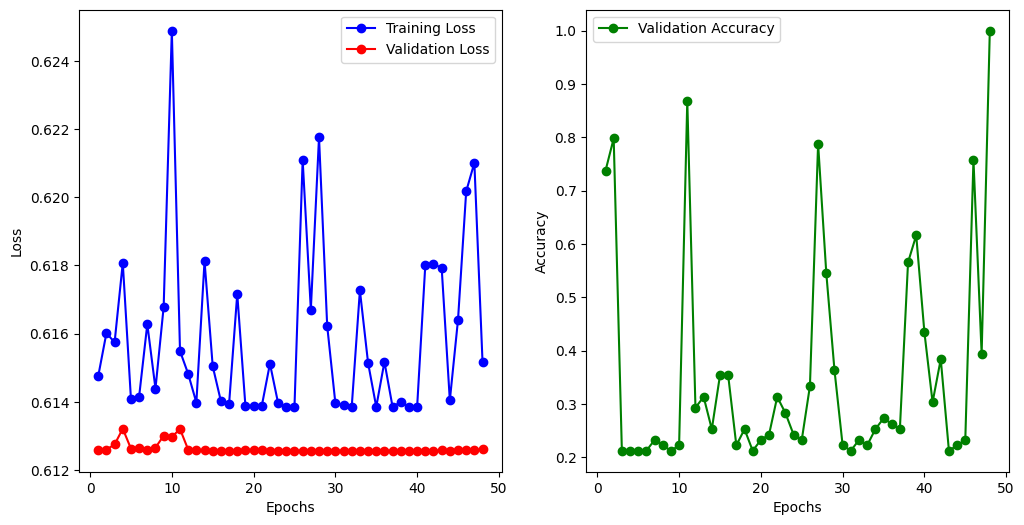

In [21]:
# Plot training history
def plot_training_history(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 6))
    
    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'go-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# Plot training history
plot_training_history(train_losses, val_losses, val_accuracies)

In [26]:


# Evaluate Model Function with Color Thresholds
def evaluate_model(model, test_loader, criterion, accuracy_threshold=0.8, loss_threshold=0.5):
    model.eval()
    test_loss = 0.0
    test_preds = []
    test_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze(1)  # Ensure outputs shape matches labels shape
            
            # Compute loss
            loss = criterion(outputs, labels.float())  # Make sure labels are float for BCEWithLogitsLoss
            test_loss += loss.item() * inputs.size(0)
            
            # Apply sigmoid to the model outputs for binary classification
            test_preds.extend(torch.sigmoid(outputs).cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_loader.dataset)
    
    test_preds_binary = (np.array(test_preds) > 0.5).astype(int)
    
    test_accuracy = np.mean(np.equal(test_preds_binary, np.array(test_labels)))
    
    if test_accuracy >= accuracy_threshold:
        accuracy_display = colored(f'{test_accuracy:.4f}', 'green')
    else:
        accuracy_display = colored(f'{test_accuracy:.4f}', 'red')
    
    if test_loss <= loss_threshold:
        loss_display = colored(f'{test_loss:.4f}', 'green')
    else:
        loss_display = colored(f'{test_loss:.4f}', 'red')
    
    print(f'Test Loss: {loss_display}, Accuracy: {accuracy_display}')

evaluate_model(model, test_loader, criterion)


/tmp/ipykernel_5717/3414121902.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  label = int(self.dataframe.iloc[idx, 1:])


Test Loss: 0.6227, Accuracy: 0.9899
